# Atmospheric composition distribution by CAMS and GOME-2

### Main goal:
* Compare GOME-2 and CAMS datasets for NO<sub>2</sub>, O<sub>3</sub> and HCHO (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import wget # Important for GOME-2
import subprocess # Important for GOME-2
import bs4 # Important for GOME-2 L2
import h5py # Important for GOME-2 L2
import geocoder
import seaborn as sns
from matplotlib import animation
from IPython.display import HTML, display

In [23]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_gome.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'O3'

# Define sensor
sensor = 'gome'
sensor_type = 'L2'
satellites = ['A', 'B', 'C']

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = -180
lon_max = 180
lat_min = -90
lat_max = 0

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define resolution (Minimum: 0.25x0.25)
lat_res = 1
lon_res = 1

# Define search period
start_date = '2021-09-01'
end_date = '2021-09-03'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In days: ('2021-09-01', '2021-09-02', '2021-09-03')


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')

The file exists, it will not be downloaded again.


In [7]:
model_ds, dates = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (latitude: 451, longitude: 900, step: 4, time: 3)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-09-01 2021-09-02 2021-09-03
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-07T19:56 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS data units (kg/m2 to molecules/cm<sup>2</sup>)

In [8]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Download and read data as xarray

In [9]:
sensor_product_names = sensor_download(sensor, sensor_type, component_nom, dates, satellites)

--2021-10-07 19:56:26--  ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/
           => '.listing'
Resolving acsaf.eoc.dlr.de (acsaf.eoc.dlr.de)... 129.247.254.12
Connecting to acsaf.eoc.dlr.de (acsaf.eoc.dlr.de)|129.247.254.12|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /gome2a/offline/2021/09/01 ... done.
==> PASV ... done.    ==> LIST ... done.

     0K ..                                                     61.4K=0.03s

2021-10-07 19:56:27 (61.4 KB/s) - '.listing' saved [2155]

Removed '.listing'.
Wrote HTML-ized index to 'data/gome/O3/index.html'.
No URLs found in ftp://acsaf.eoc.dlr.de/gome2a/offline/2021/09/01/.
File 'data/gome/O3/2021-09-01/A/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20210901013613_051_METOPA_77149_DLR_04.HDF5' already there; not retrieving.
File 'data/gome/O3/2021-09-01/A/GOME_O3-NO2-NO2Tropo-BrO-SO2-H2O-HCHO_L2_20210901031737_051_METOPA_77150_DLR_04.HDF5' already there; not 

In [10]:
sensor_ds, _, _ = sensor_read(sensor, sensor_type, component_nom, satellites)
sensor_ds

/tmp/ipykernel_2266813/79800330.py:95: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_2266813/79800330.py:95: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts
/tmp/ipykernel_2266813/79800330.py:95: RuntimeWarning: invalid value encountered in true_divide
  zi = zi / counts


<xarray.Dataset>
Dimensions:     (latitude: 180, longitude: 360, time: 3)
Coordinates:
  * latitude    (latitude) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude   (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time        (time) datetime64[ns] 2021-09-01 2021-09-02 2021-09-03
Data variables:
    O3total     (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    delta_time  (time, latitude, longitude) datetime64[ns] NaT NaT ... NaT NaT

## 4. Match data

In [11]:
kernels_method = None
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column)
match_table

FOR EST. TIME: 2021-09-01T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2021-09-02T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2021-09-03T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The model does not contain levels data.
The columns model data will be matched to the sensor data by nearest neighbours.


,latitude,longitude,O3total,delta_time,time,step_index,model_column
0,-89.5,-179.5,NaN,2021-09-01 12:00:00,2021-09-01,2,221.916626
1,-89.5,-178.5,NaN,2021-09-01 12:00:00,2021-09-01,2,221.973450
2,-89.5,-177.5,NaN,2021-09-01 12:00:00,2021-09-01,2,222.011520
3,-89.5,-176.5,NaN,2021-09-01 12:00:00,2021-09-01,2,222.068832
4,-89.5,-175.5,NaN,2021-09-01 12:00:00,2021-09-01,2,222.107315
...,...,...,...,...,...,...,...
32395,-0.5,175.5,260.721369,2021-09-03 21:41:54,2021-09-03,3,257.327637
32396,-0.5,176.5,262.912792,2021-09-03 21:41:54,2021-09-03,3,257.085724
32397,-0.5,177.5,260.944862,2021-09-03 21:41:54,2021-09-03,3,255.758072
32398,-0.5,178.5,NaN,2021-09-03 21:41:54,2021-09-03,3,254.980209


## 5. Merge data and calculate difference

In [12]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

O3total  step_index  model_column  difference
latitude longitude time                                                     
-89.5    -179.5    2021-09-01      NaN           2    221.916626         NaN
                   2021-09-02      NaN           2    219.907120         NaN
                   2021-09-03      NaN           2    232.778458         NaN
         -178.5    2021-09-01      NaN           2    221.973450         NaN
                   2021-09-02      NaN           2    219.950974         NaN
...                                ...         ...           ...         ...
-0.5      178.5    2021-09-02      NaN           2    257.984009         NaN
                   2021-09-03      NaN           3    254.980209         NaN
          179.5    2021-09-01      NaN           3    257.529785         NaN
                   2021-09-02      NaN           2    256.912872         NaN
                   2021-09-03      NaN           2    256.005981         NaN

[97200 rows x 4 columns]

In [13]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,O3total,step_index,model_column,difference
count,60863.000000,97200.000000,97200.000000,60863.000000
mean,309.659601,1.889321,279.509016,8.157582
std,44.841728,0.854858,49.967940,8.837516
min,173.133179,0.000000,180.820511,-42.188867
25%,279.461088,1.000000,236.014069,3.450996
50%,301.952037,2.000000,278.412994,6.819421
75%,334.664407,2.000000,308.205292,11.250331
max,487.103351,3.000000,466.626373,105.090820


## 6. Show comparison plots

### Select plot dates

In [14]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-09' '2021-09' '2021-09']


### Select plot extent

In [15]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((-180, -90), (180, 0))


### Compare CAMS and GOME-2 total columns

In [24]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'animated'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection=ccrs.Orthographic(180, -90)
color_scale = 'jet'

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 1.10, 
                          model_type, sensor_type, range_type, sensor_column, distribution_type, projection, 
                          color_scale, vmin_manual, vmax_manual)

2021-10-07 20:18:05,704 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## 7. Retrieve nearest values to specific latitude and longitude

O3total  step_index  \
lat_search lon_search latitude longitude time                                 
-80        30         -74.5    37.5      2021-09-01  201.787537           1   
                      -70.5    31.5      2021-09-02  244.555328           1   
                      -72.5    29.5      2021-09-03  228.724925           1   
-70        30         -69.5    27.5      2021-09-01  222.646996           1   
                      -70.5    31.5      2021-09-02  244.555328           1   
                               30.5      2021-09-03  227.060491           1   
-50        30         -50.5    29.5      2021-09-01  417.708496           1   
                                         2021-09-02  431.327682           1   
                                         2021-09-03  366.152809           1   

                                                     model_column  difference  
lat_search lon_search latitude longitude time                                  
-80        30         -74.5    37.5      2021-09-01    194.253128    7.534409  
                      -70.5    31.5      2021-09-02    227.956970   16.598358  
                      -72.5    29.5      2021-09-03    223.512299    5.212626  
-70        30         -69.5    27.5      2021-09-01    213.320175    9.326820  
                      -70.5    31.5      2021-09-02    227.956970   16.598358  
                               30.5      2021-09-03    227.314377   -0.253886  
-50        30         -50.5    29.5      2021-09-01    392.126831   25.581665  
                                         2021-09-02    405.738617   25.589066  
                                         2021-09-03    348.998749   17.154060

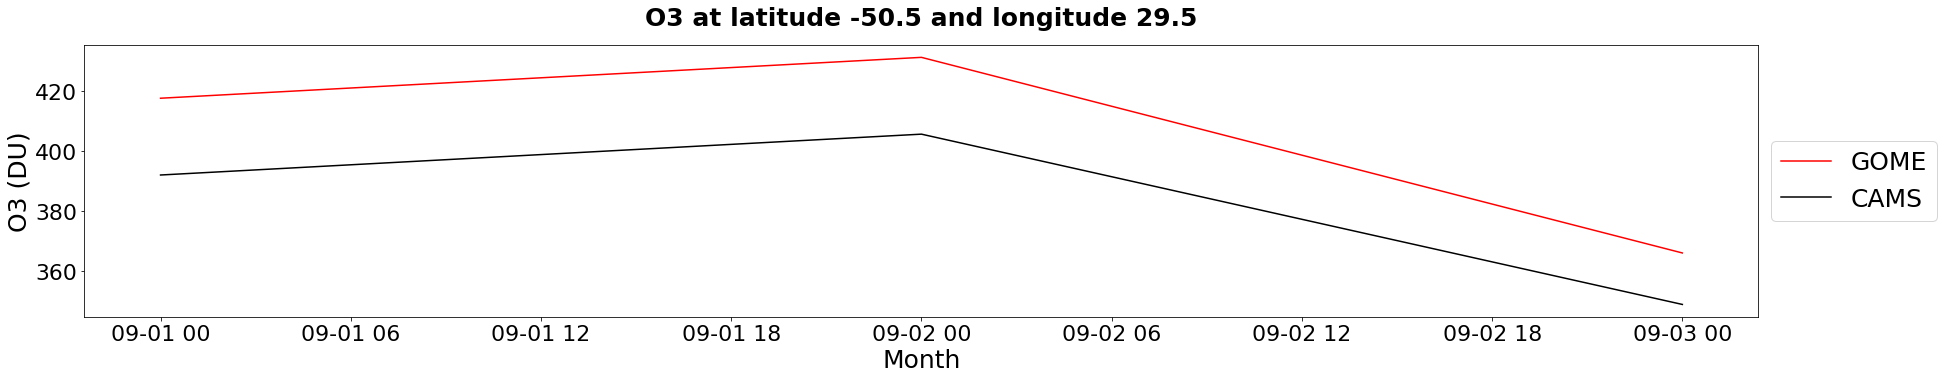

In [ ]:
coords_search_list = (-80, 30,
                      -70, 30,
                      -50, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor_column, sensor, model, plot_dates, units)
retrieval_table_all

## 8. Scatter plots by bbox

Fit equation: O3_model = O3_sensor * 0.95 + (7.52E+00)
Coefficient of determination (R2): 0.96


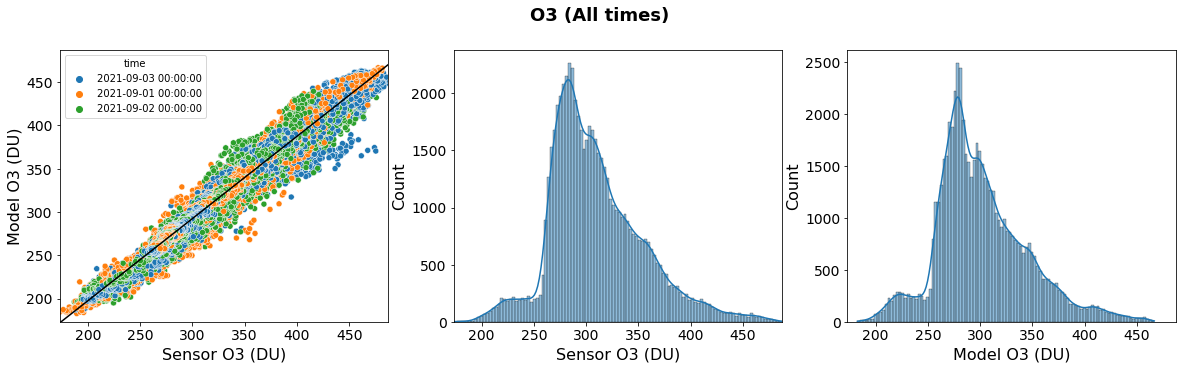

In [ ]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [ ]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2021-09-01T00:00:00.000000000, 2021-09-02T00:...","((-180, -90), (180, 0))",0.961307,0.94937,7.520384


## 9. Scatter plots by season

Fit equation: O3_model = O3_sensor * 0.95 + (7.52E+00)
Coefficient of determination (R2): 0.96


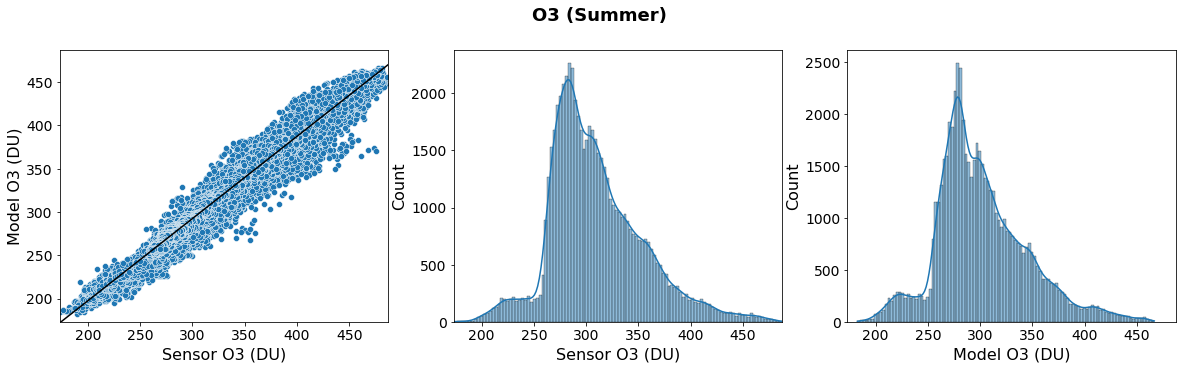

In [ ]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_bbox)

In [ ]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Summer,"((-180, -90), (180, 0))",0.961307,0.94937,7.520384


## 10. Scatter plots by country (Google API required!)

In [ ]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual
plot_countries = ['France', 'Germany', 'Italy']
summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, 
                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'individual' # aggregated or individual\nplot_countries = ['France', 'Germany', 'Italy']\nsummary = scatter_plot(merge_table.dropna(), component_nom, units, sensor_column, sensor, \n                       plot_dates, 1, extent_definition, show_seasons, scatter_plot_type, plot_countries)\n"

In [ ]:
#summary